In [97]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import pstats

from collections import defaultdict
from profile import Profile as PythonProfiler
from tqdm import tqdm_notebook

import pandas as pd
import seaborn as sns
import hippiehug

from msgpack import packb

sys.path.append('..')

from claimchain import State, View, LocalParams
from claimchain.core import encode_claim
from claimchain.utils.wrappers import serialize_object, Blob, Tree, check_evidence
from claimchain.utils.profiling import Profiler, profiled

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/bogdan/Workspace/claimchain-simulations/venv/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [123]:
sns.set_context("paper", font_scale=2.5)
sns.set_style("white")
sns.set_palette('colorblind', n_colors=4)

In [99]:
sys.version

'3.5.2 (default, Nov 23 2017, 16:37:01) \n[GCC 5.4.0 20160609]'

## Generating test data

This simulates `nb_readers` readers, each with own set of cryptographic keys. Every reader gets a random **32 byte** label associated with them, and **512 bytes** randomly generated claim about them.

The random capability matrix is generated: for each of the target readers _t_, `nb_caps_per_reader` other readers are randomly chosen. These are the ones that the reader _t_ will be able to access claims about, i.e. be included in _t_'s capability list.



In [100]:
def generate_test_data(nb_readers=1000, nb_caps_per_reader=1, label_size=32, claim_size=512):
    labels = [b'label_' + os.urandom(label_size - 6) for _ in range(nb_readers)]
    claims = [b'claim_' + os.urandom(claim_size - 6) for _ in range(nb_readers)]

    params = [LocalParams.generate() for _ in range(nb_readers)]

    reader_graph = {}
    for reader_index in range(nb_readers):
        cap = random.sample(range(nb_readers), nb_caps_per_reader)
        reader_graph[reader_index] = cap

    return reader_graph, labels, claims, params

## Simulating the owner
The owner builds a state consisting of the claims generated above, with the access capabilities as generated above. The state is committed to the chain.

In [101]:
def commit_claims(reader_graph, labels, claims, params):
    owner_params = LocalParams.generate()
    with owner_params.as_default():
        state = State()
        
        # Add claims
        for label, claim in zip(labels, claims):
            state[label] = claim
        
        # Define the capability lists
        for reader_index, cap_indexes in reader_graph.items():
            reader_dh_pk = params[reader_index].dh.pk
            cap_labels = [labels[cap_index] for cap_index in cap_indexes]
            state.grant_access(reader_dh_pk, cap_labels)
        
        # Commit
        chain = hippiehug.Chain()
        state.commit(target_chain=chain)

        return chain, state

## Compute evidence

Evidence of claim inclusion can be done either on the owner's side or on the client's side depending on the setting. We measure the size of evidence paths.

In [102]:
@profiled
def compute_single_evidence_path(tree, lookup_key):
    root, evidence = tree.evidence(lookup_key)
    assert evidence[-1].key == lookup_key
    return root, evidence

@profiled
def check_single_evidence_path(root_hash, evidence, lookup_key):
    return check_evidence(root_hash, evidence, lookup_key)
        
def compute_random_evidences(state, nb_samples=200):
    assert hasattr(state, '_enc_items_map')
    tree = state._tree
    evidence_map = {}
    for lookup_key in random.sample(list(state._enc_items_map), nb_samples):
        evidence_map[lookup_key] = \
                compute_single_evidence_path(tree, lookup_key)
    return evidence_map

def check_single_evidence(tree, evidence):
    validation_tree = Tree(ObjectStore(evidence), root_hash=tree.root_hash)
    

def serialize_evidence(evidence):
    return packb([serialize_object(node) for node in evidence])

## Simulating the readers

In [103]:
def read_claims(chain, reader_graph, labels, claims, params):
    # Go over all of the readers
    view = View(chain)
    for reader_index, caps_indexes in reader_graph.items():
        reader_params = params[reader_index]
        with reader_params.as_default():
            # Retrieve each of the accessible labels
            for cap_index in caps_indexes:
                label = labels[cap_index]
                read_claim = view[labels[cap_index]]
                
                # Check the value matches original to be sure
                assert read_claim == claims[cap_index]
    return view

## Size-dependent measurements and plots

Sizes of claim sets to be simulated

In [104]:
nb_claims_range = range(100, 6000, 500)
list(nb_claims_range)

[100, 600, 1100, 1600, 2100, 2600, 3100, 3600, 4100, 4600, 5100, 5600]

In [105]:
evidence_length_data = pd.DataFrame(columns=('avg', 'std'))
evidence_size_data = pd.DataFrame(columns=('avg', 'std'))
evidence_computation_timing_data = pd.DataFrame(columns=('avg', 'std'))
evidence_verification_timing_data = pd.DataFrame(columns=('avg', 'std'))
store_snapshots = []

for nb_claims in nb_claims_range:
    reader_graph, labels, claims, params = generate_test_data(
        nb_readers=nb_claims, nb_caps_per_reader=1)
    
    # Commit claims
    chain, state = commit_claims(reader_graph, labels, claims, params)
    # Compute evidence of inclusion for each claims
    profiler = Profiler()
    with profiler.as_default():
        evidence_map = compute_random_evidences(state, nb_samples=200)
        for lookup_key, (root_hash, evidence) in evidence_map.items():
            assert check_single_evidence_path(root_hash, evidence, lookup_key)
        
    compute_stats = profiler.compute_stats()['compute_single_evidence_path']
    verification_stats = profiler.compute_stats()['check_single_evidence_path']
    
    evidence_computation_timing_data.loc[nb_claims] = (compute_stats['avg'], compute_stats['std'])
    evidence_verification_timing_data.loc[nb_claims] = (verification_stats['avg'], verification_stats['std'])
    
    evidence_lengths = np.array([len(evidence) for root, evidence in evidence_map.values()])
    evidence_length_data.loc[nb_claims] = (evidence_lengths.mean(), evidence_lengths.std())

    evidence_sizes = np.array([len(serialize_evidence(evidence)) for root, evidence in evidence_map.values()])
    evidence_size_data.loc[nb_claims] = (evidence_sizes.mean(), evidence_sizes.std())
    
    store_snapshots.append(chain.store.copy())

Evidence size

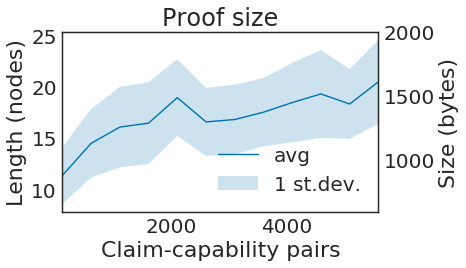

In [124]:
fig, ax1 = plt.subplots(figsize=(7, 4))
ax1.plot(nb_claims_range, evidence_length_data['avg'])
ax1.fill_between(nb_claims_range,
                 evidence_length_data['avg'] - evidence_length_data['std'],
                 evidence_length_data['avg'] + evidence_length_data['std'],
                 alpha=.2,
                 label='1 st.dev.')
#constant = 2.2
#ax1.plot(nb_claims_range, constant * np.log(nb_claims_range),
#         color='black', alpha=.5, linestyle='--', label='%1.1f · log(n)' % constant)
ax1.set_xlabel('Claim-capability pairs')
ax1.set_ylabel('Length (nodes)')
ax1.legend(loc=4)

ax2 = ax1.twinx()

# Plots happen to almost coincide on this scale, so setting alpha to zero.
# Only plotting the invisible lines to show the right (bytes) scale.
ax2.plot(nb_claims_range, evidence_size_data['avg'],
         color='red', alpha=0)
ax2.fill_between(nb_claims_range,
                 evidence_size_data['avg'] - evidence_size_data['std'],
                 evidence_size_data['avg'] + evidence_size_data['std'],
                 color='red', alpha=0)
ax2.set_ylabel('Size (bytes)')
plt.xlim(100, 5600)

plt.tight_layout()
plt.title('Proof size')

plt.savefig('../data/images/evidence_size.pdf')

Evidence timing

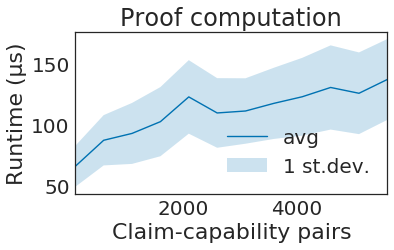

In [107]:
evidence_timing_data_ms = evidence_computation_timing_data * 10e+6

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(nb_claims_range, evidence_timing_data_ms['avg'])
ax.fill_between(nb_claims_range,
                 evidence_timing_data_ms['avg'] - evidence_timing_data_ms['std'],
                 evidence_timing_data_ms['avg'] + evidence_timing_data_ms['std'],
                 alpha=.2,
                 label='1 st.dev.')
#constant = 14
#plt.plot(nb_claims_range, constant * np.log(nb_claims_range),
#        color='black', alpha=.5, linestyle='--', label='%1.1f · log(n)' % constant)
ax.legend(loc=4)
ax.set_xlabel('Claim-capability pairs')
ax.set_xlim(100, 5600)
ax.set_ylabel('Runtime (µs)')
ax.set_title('Proof computation')

plt.tight_layout()

plt.savefig('../data/images/evidence_computation_timing.pdf')

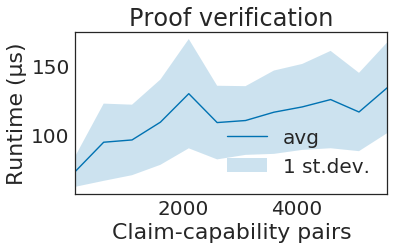

In [108]:
evidence_timing_data_ms = evidence_verification_timing_data * 10e+6

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(nb_claims_range, evidence_timing_data_ms['avg'])
ax.fill_between(nb_claims_range,
                 evidence_timing_data_ms['avg'] - evidence_timing_data_ms['std'],
                 evidence_timing_data_ms['avg'] + evidence_timing_data_ms['std'],
                 alpha=.2,
                 label='1 st.dev.')
#constant = 20
#plt.plot(nb_claims_range, constant * np.log(nb_claims_range),
#         color='black', alpha=.5, linestyle='--', label='%1.1f · log(n)' % constant)
ax.legend(loc=4)
ax.set_xlabel('Claim-capability pairs')
ax.set_xlim(100, 5600)
ax.set_ylabel('Runtime (µs)')
ax.set_title('Proof verification')

plt.tight_layout()

plt.savefig('../data/images/evidence_verification_timing.pdf')

In [109]:
build_tree_timing_data = pd.DataFrame(columns=['avg', 'std'])
store_snapshots_1 = []

for nb_claims in tqdm_notebook(nb_claims_range):
    profiler = Profiler()
    reader_graph, labels, claims, params = generate_test_data(
        nb_readers=nb_claims, nb_caps_per_reader=1)
    stats_per_iteration = []
    for n in range(20):
        with profiler.as_default():
            chain, state = commit_claims(reader_graph, labels, claims, params)
            stats = profiler.compute_stats()
            stats_per_iteration.append(stats)
    timings = np.array([stats['_build_tree']['avg'] for stats in stats_per_iteration])
    build_tree_timing_data.loc[nb_claims] = (np.mean(timings), np.std(timings))
    
    store_snapshots_1.append(chain.store.copy())

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

/home/bogdan/Workspace/claimchain-simulations/venv/lib/python3.5/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


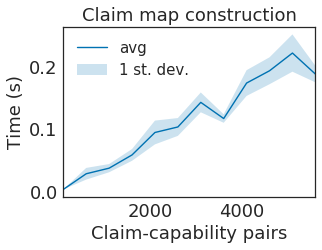

In [110]:
fig, ax = plt.subplots()

ax.plot(nb_claims_range, build_tree_timing_data['avg'])
ax.fill_between(nb_claims_range,
                 build_tree_timing_data['avg'] - build_tree_timing_data['std'],
                 build_tree_timing_data['avg'] + build_tree_timing_data['std'],
                 alpha=.2,
                 label='1 st. dev.')

ax.legend(loc=2, fontsize=15)
ax.set_title('Claim map construction')
ax.set_xlabel('Claim-capability pairs')
ax.set_xlim(100, 5600)
ax.set_ylabel('Time (s)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

fig.set_figwidth(5)
fig.set_figheight(4)
fig.set_tight_layout(tight=True)
    
fig.savefig('../data/images/tree_build_timing.pdf')

Comparing the current timing for build the tree vs. inefficient one.

In [19]:
def is_leaf(obj):
    return isinstance(obj, hippiehug.Nodes.Leaf)
    
def is_node(obj):
    return isinstance(obj, hippiehug.Nodes.Branch)

def is_block(obj):
    return isinstance(obj, hippiehug.Block)
    
def is_blob(obj):
    return isinstance(obj, Blob)

def calc_objects_size(filter_fn, store):
    objs = [serialize_object(obj) for obj in filter(filter_fn, store.values())]
    return len(packb(objs))

In [95]:
current_store_snapshots = store_snapshots_1
sizes_data = pd.DataFrame(columns=['Tree nodes', 'Tree leaves', 'Block'])

for nb_claims, snapshot in zip(nb_claims_range, current_store_snapshots):
    sizes_data.loc[nb_claims] = (
        calc_objects_size(is_node, snapshot),
        calc_objects_size(is_blob, snapshot) + calc_objects_size(is_leaf, snapshot),
        calc_objects_size(is_block, snapshot),
    )
sizes_data

,Tree nodes,Tree leaves,Block
100,26643,75506,490
600,159043,452998,490
1100,292323,830498,490
1600,427043,1207997,490
2100,560243,1585493,490
2600,692963,1962988,490
3100,826963,2340478,490
3600,960803,2717971,490
4100,1094243,3095478,490
4600,1228483,3472962,490


/home/bogdan/Workspace/claimchain-simulations/venv/lib/python3.5/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


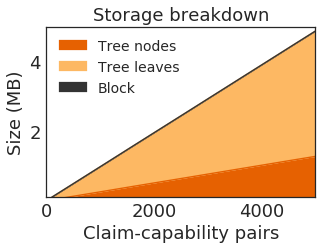

In [127]:
sns.set_palette(['#e66101', '#fdb863', '#333333'])

unit = 1 / (1024. * 1024.)
fig, ax = plt.subplots()

sizes_data_mb = sizes_data * unit
sizes_data_mb.plot.area(ax=ax, legend=None)
ax.legend(fontsize=14, loc=2)
ax.set_title('Storage breakdown')
ax.set_xlabel('Claim-capability pairs')
ax.set_ylabel('Size (MB)')
ax.set_xlim(0, 5000)
ax.set_ylim(0.1, 5)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

fig.set_figwidth(5)
fig.set_figheight(4)
fig.set_tight_layout(tight=True)

fig.savefig('../data/images/storage_size.pdf')

Block size

In [42]:
import msgpack
len(msgpack.packb(serialize_object(chain.store.get(chain.head))))

488

## Timing core operations

In [53]:
def simulate():
    reader_graph, labels, claims, params = generate_test_data()

    # Commit claims
    chain, state = commit_claims(reader_graph, labels, claims, params)
    # Simulate readers
    view = read_claims(chain, reader_graph, labels, claims, params)
    # Compute evidence of inclusion for each claim
    evidence_map = compute_random_evidences(state, 2000)

### High-level profiling

In [54]:
profiler = Profiler()
with profiler.as_default():
    simulate()
    stats = profiler.compute_stats()

In [55]:
df = pd.DataFrame(stats)
df = df.T
stat_cols = ['avg', 'max', 'min', 'std']
df = df[stat_cols].apply(lambda value: value * 1000)  # milliseconds
df = df.round(2)
df

,avg,max,min,std
_build_tree,31.17,31.17,31.17,NaN
compute_single_evidence_path,0.01,0.22,0.00,0.01
compute_vrf,1.10,1.95,0.83,0.14
decode_capability,0.12,0.22,0.11,0.01
decode_claim,1.90,3.16,1.57,0.17
encode_capability,0.11,0.21,0.10,0.02
encode_claim,1.15,2.03,0.88,0.14
get_capability_lookup_key,0.09,0.16,0.09,0.01
verify_vrf,1.84,3.06,1.51,0.16


In [56]:
pretty_df = df[['avg', 'std']].sort_index()
readable_procedure_names = {
    '_build_tree': 'Tree construction',
    'compute_single_evidence_path': 'Single entry inclusion proof computation',
    'compute_vrf': 'VRF computation',
    'decode_capability': 'Single-label capab. decoding',
    'decode_claim': 'Claim decoding',
    'encode_capability': 'Single-label capab. encoding',
    'encode_claim': 'Claim encoding',
    'get_capability_lookup_key': 'Single-label capab. lookup key computation',
    'verify_vrf': 'VRF verification',
}
pretty_df.index = [readable_procedure_names[func_name] for func_name in pretty_df.index]
pretty_df.sort_values(by='avg', inplace=True)
pretty_df.columns = ['avg (ms)', 'std']
print(pretty_df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  avg (ms) &   std \\
\midrule
Single entry inclusion proof computation   &      0.01 &  0.01 \\
Single-label capab. lookup key computation &      0.09 &  0.01 \\
Single-label capab. encoding               &      0.11 &  0.02 \\
Single-label capab. decoding               &      0.12 &  0.01 \\
VRF computation                            &      1.10 &  0.14 \\
Claim encoding                             &      1.15 &  0.14 \\
VRF verification                           &      1.84 &  0.16 \\
Claim decoding                             &      1.90 &  0.17 \\
Tree construction                          &     31.17 &   NaN \\
\bottomrule
\end{tabular}



### Low-level profiling

Full simulation

In [57]:
profiler = PythonProfiler()
profiler.runctx("simulate()", globals(), locals())
profiler.create_stats()

profiler.print_stats(sort='cumtime')

         2719542 function calls (2566705 primitive calls) in 9.604 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    9.604    9.604 profile:0(simulate())
        1    0.000    0.000    9.598    9.598 :0(exec)
        1    0.011    0.011    9.598    9.598 <string>:1(<module>)
        1    0.000    0.000    9.564    9.564 <ipython-input-53-770b847371ee>:1(simulate)
9001/7001    0.070    0.000    8.599    0.001 profiling.py:34(wrapped)
        1    0.012    0.012    4.966    4.966 <ipython-input-31-4a2ad94190eb>:1(read_claims)
     1000    0.005    0.000    4.896    0.005 state.py:252(__getitem__)
     1000    0.006    0.000    4.084    0.004 state.py:241(_lookup_claim)
     1000    0.020    0.000    3.933    0.004 core.py:72(decode_claim)
        1    0.004    0.004    3.832    3.832 <ipython-input-29-04883c6cd016>:1(commit_claims)
        1    0.006    0.006    3.784    3.784 state.py:99(commit